# Project 🚗 Vehicle Silhouette Classification

## Problem Statement


Das Unternehmen Prospect Auto möchte ein Modell entwickeln, das Fahrzeuge basierend auf Silhouetten-Daten einer der drei Fahrzeugklassen zuordnet.  

Die Klassifikation soll auf Grundlage numerischer Merkmale erfolgen, die aus den Bilddaten abgeleitet wurden.

Ziel ist es, ein Machine-Learning-Modell zu trainieren, das diese Aufgabe als **überwachtes Klassifikationsproblem** löst. Dafür steht ein strukturierter<br> 
Datensatz zur Verfügung, der sowohl die Eingangsmerkmale als auch die Zielklasse enthält.


## Import Libraries

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pprint
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support

## Import the CSV file and examine the data structure

In [190]:
raw_data = pd.read_csv("vehicle.csv")
df = raw_data.copy()
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null    float64
 13  scaled_radius_of_gyr

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

## Visuelle Analyse des Datensatzes

### **Verteilung der Zielklassen**

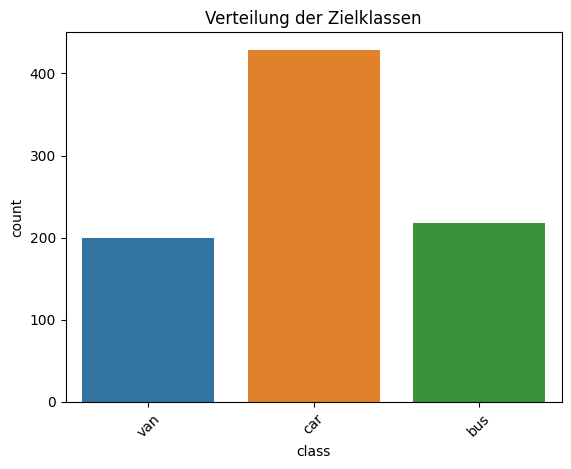

In [191]:
# Farb Codierung der Klassen
class_colors = {
    "van": "#1f77b4",   # blau
    "car": "#ff7f0e",   # orange
    "bus": "#2ca02c",   # grün
}

order = ["van", "car", "bus"]

colors = [class_colors[cls] for cls in order]

sns.countplot(data=df, x="class", hue="class", order=order, palette=class_colors, legend=False)
plt.title("Verteilung der Zielklassen")
plt.xticks(rotation=45)
plt.show()



**Erkenntnisse:**<br>

Die Klasse car macht mit Abstand den größten Anteil im Datensatz aus und liegt bei etwa 50 % der Gesamtverteilung. Die Klassen van und bus sind deutlich kleiner vertreten und machen zusammen die andere Hälfte aus – mit einem leichten Übergewicht bei bus. Insgesamt zeigt sich eine moderate Klassenunbalance, die bei der Modellierung berücksichtigt werden sollte.

Ein möglicher Effekt dieser Verteilung ist, dass ein Modell dazu neigt, die dominante Klasse car zu bevorzugen. Dadurch könnten die kleineren Klassen (van und bus) schlechter erkannt werden. Um dem entgegenzuwirken, kann beim Trainieren des Modells die Option class_weight="balanced" eingesetzt werden. Damit werden die Klassen nach ihrer Häufigkeit gewichtet, sodass auch weniger vertretene Klassen angemessen berücksichtigt werden. Besonders bei der Bewertung des Modells sollten neben der Accuracy auch Metriken wie Precision, Recall und der F1-Score betrachtet werden, um eine faire Aussage über die Modellqualität zu erhalten.


### **Verteilung der Features nach Zielklassen**

#### - Pairplot

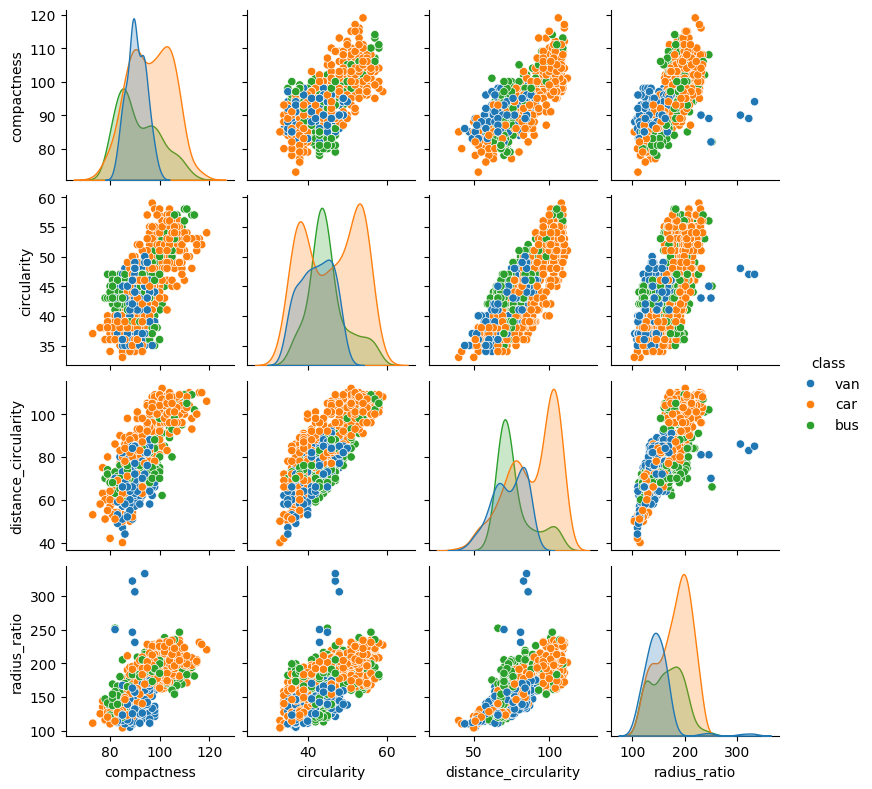

In [192]:
subset_cols = df.columns[:4].tolist() + ["class"]
sns.pairplot(df[subset_cols], hue="class",  height=2.0, aspect=1)
plt.show()


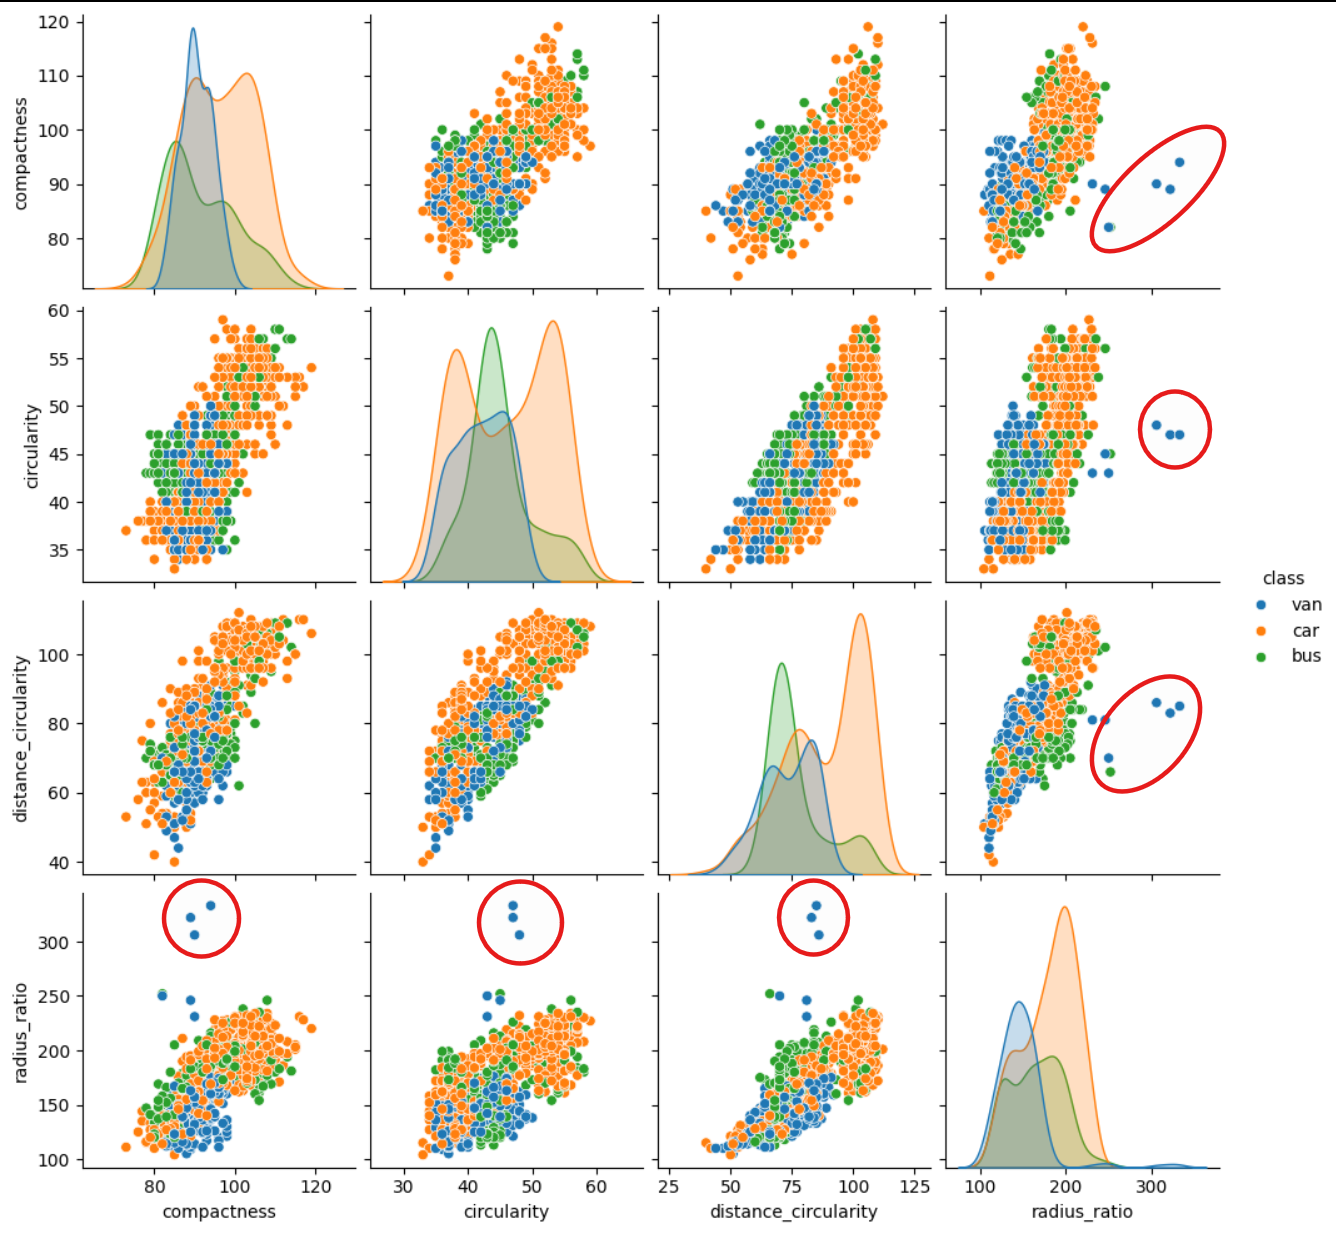

In [193]:
from IPython.display import Image
Image(filename="verteilungsanalyse_plot.png", width=870)  # Breite in Pixeln

**Erkenntnisse**

Der Pairplot zeigt, wie sich die verschiedenen Merkmale im Zusammenspiel mit der Zielklasse verhalten. Auf den ersten Blick fällt auf, dass sich einige Klassen in bestimmten Merkmalskombinationen gut voneinander abgrenzen lassen. Zum Beispiel bilden sich bei compactness in Kombination mit anderen Features dichte Punktwolken, wobei sich die Klasse van deutlich vom Rest abhebt – die Punkte liegen konzentriert in einem engen Bereich und sind kaum mit car oder bus durchmischt.

Besonders deutlich wird das auch in der Kombination radius_ratio vs. compactness oder circularity. Hier treten vereinzelt Punkte der Klasse van außerhalb des restlichen Punktmusters auf – also potenzielle Ausreißer, die sich visuell leicht erkennen lassen. Solche Ausreißer sind auf mehreren Achsen sichtbar und sollten vor dem Modelltraining genauer untersucht werden, um zu entscheiden, ob sie entfernt oder besonders behandelt werden sollen.

Die diagonalen Dichteverläufe zeigen zusätzlich, wie die Klassen innerhalb eines einzelnen Merkmals verteilt sind. Bei compactness ist klar zu erkennen, dass van sehr eng gestreut ist, während car eine breitere Verteilung zeigt.

Einige Merkmalskombinationen zeigen auch sehr klare lineare Muster – z. B. zwischen compactness und circularity oder distance_circularity und radius_ratio. Das deutet auf starke Zusammenhänge hin, die später bei der Feature-Selektion berücksichtigt werden sollten, um Redundanz zu vermeiden.

Zusammenfassend hilft der Pairplot dabei, erste visuelle Eindrücke zu gewinnen: Welche Klassen liegen in welchen Merkmalsräumen eng beieinander? Wo gibt es klare Trennungen? Und wo liegen möglicherweise Punkte, die aus dem Muster fallen?


#### - Heatmap

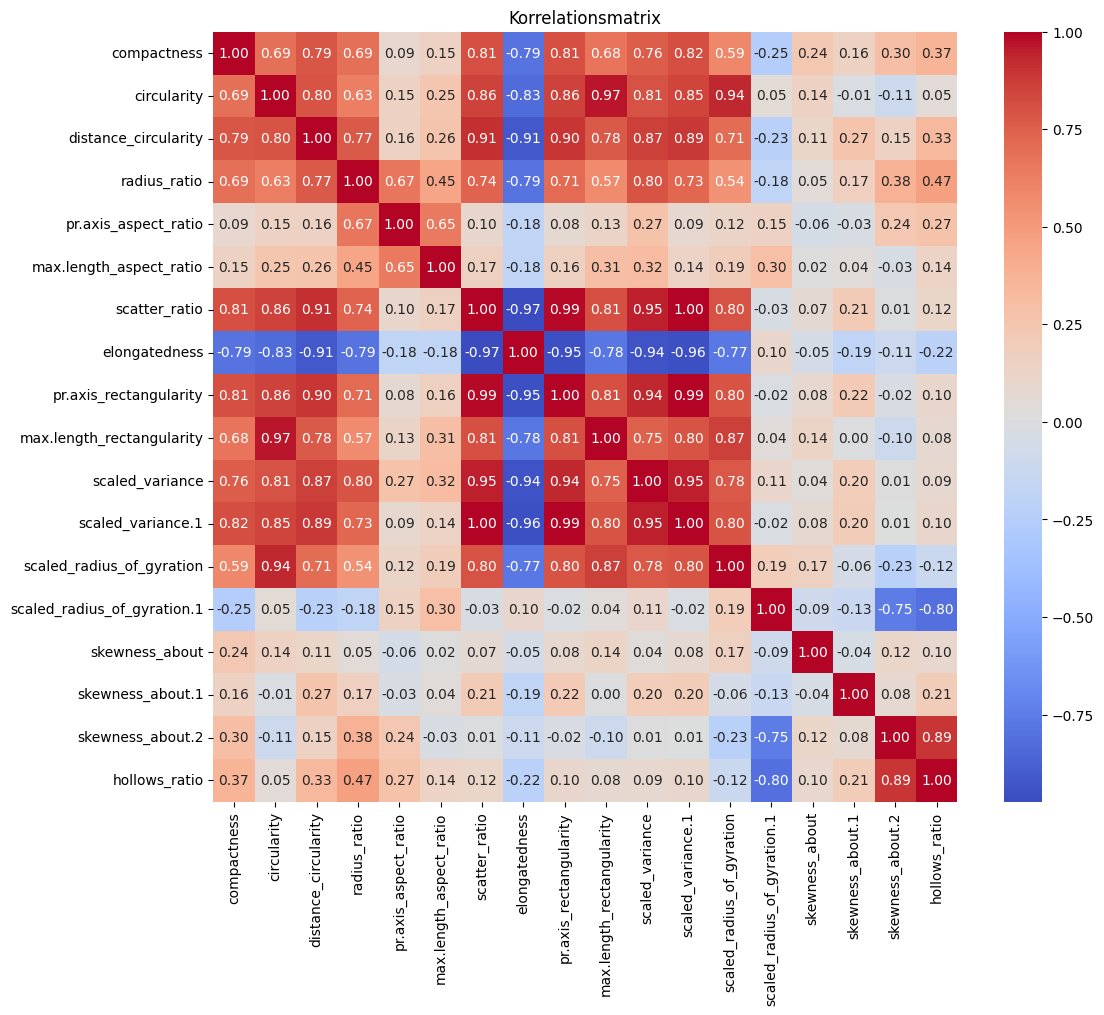

In [194]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korrelationsmatrix")
plt.show()


**Erkenntnisse**<br>

Beim Betrachten der Korrelationsmatrix ist mir aufgefallen, dass einige Merkmale sehr stark miteinander zusammenhängen. Zum Beispiel sieht man eine hohe Korrelation zwischen `max.length_rectangularity` und `circularity` sowie zwischen `scaled_variance` und `scaled_variance.1`. Auch wenn diese Merkmale keine exakten Duplikate sind, liefern sie fast die gleiche Information. Das kann beim Modellieren zu Problemen führen, weil das Modell dadurch eine gewisse Information doppelt berücksichtigt (Multikollinearität).

Ein weiteres spannendes Merkmal ist `elongatedness`. Es zeigt eine starke negative Korrelation zu vielen anderen Features. Das bedeutet: Wenn `elongatedness` größer wird, nehmen viele andere Werte gleichzeitig ab – es verhält sich also oft entgegengesetzt.

Für den nächsten Schritt in der Modellierung ist es deshalb sinnvoll, sich zu überlegen, welche Merkmale man wirklich braucht. In Gruppen mit sehr ähnlichen Features reicht es oft, nur eines davon zu verwenden. So wird das Modell einfacher, robuster und kann besser auf neue Daten generalisieren.


#### - Boxplot

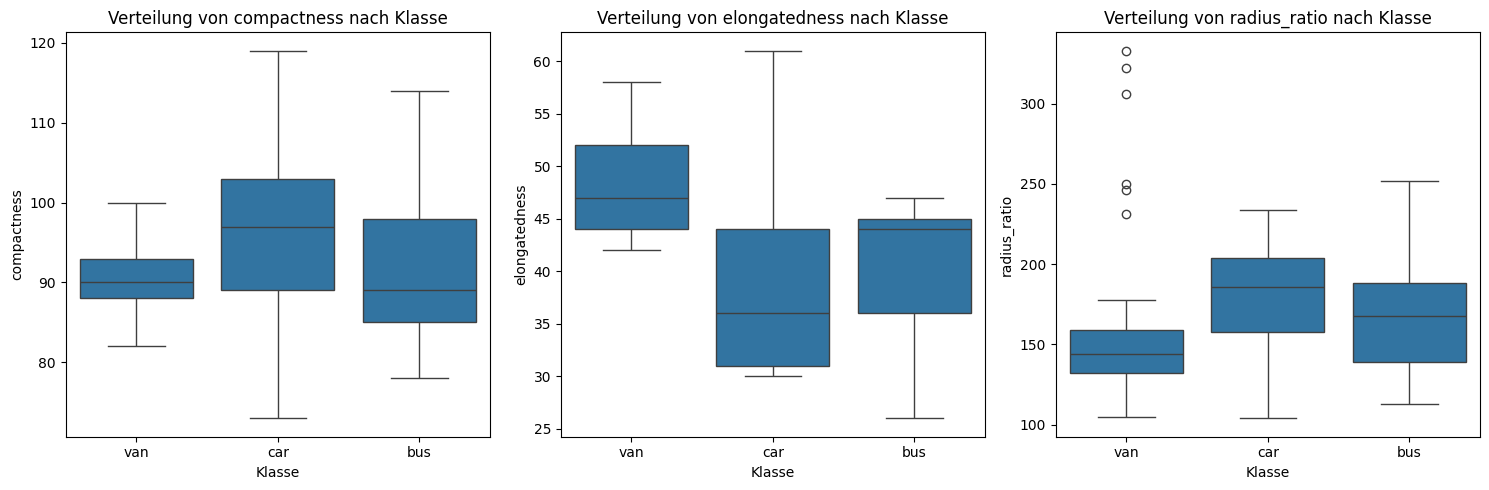

In [195]:
# Features, die du vergleichen möchtest
features = ["compactness", "elongatedness", "radius_ratio"]

# Erzeuge Subplots
plt.figure(figsize=(15, 5))

for i, feature in enumerate(features):
    plt.subplot(1, 3, i + 1)  # 1 Zeile, 3 Spalten, i-te Position
    sns.boxplot(data=df, x="class", y=feature)
    plt.title(f"Verteilung von {feature} nach Klasse")
    plt.xlabel("Klasse")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


**Boxplot-Vergleich: compactness, elongatedness, radius_ratio**<br>
(Auswahl basierend auf den vorangegangenen Plots)

***compactness***  
Die Werte für compactness liegen bei der Klasse van relativ eng um den Wert 90. Diese kompakte Verteilung lässt auf eine geringe Streuung schließen und deutet darauf hin, dass van in diesem Merkmal eine klar erkennbare Struktur zeigt. Im Vergleich dazu sind car und bus deutlich breiter verteilt. Besonders car hat einen höheren Median, was bedeutet, dass Fahrzeuge dieser Klasse tendenziell eine höhere Kompaktheit aufweisen. bus liegt im Median zwar ähnlich wie van, hat aber eine wesentlich breitere Verteilung, wodurch es stärker mit den anderen Klassen überlappt. Insgesamt zeigt sich, dass compactness gut geeignet ist, um van von den anderen Klassen zu unterscheiden.

***elongatedness***  
Bei elongatedness sind die Unterschiede zwischen den Klassen besonders deutlich. van zeigt hier einen klar höheren Median als car und bus, und die Boxplot-Bereiche überlappen sich kaum. Zwischen van und car scheint sogar eine nahezu vollständige Trennung möglich zu sein. Auch zu bus ist die Trennung sehr deutlich – es gibt nur minimale Überlappung in den Randbereichen. Diese klare Differenz macht elongatedness zu einem wertvollen Merkmal für die Klassifikation. Gleichzeitig stellt sich die Frage, inwiefern das Modell Gefahr läuft, sich zu stark auf dieses eine Merkmal zu verlassen. Ein so dominantes Feature kann zwar die Genauigkeit im Training erhöhen, birgt aber auch das Risiko von Overfitting, falls die Verteilung in zukünftigen Daten nicht stabil bleibt.

***radius_ratio***  
Die Verteilung von radius_ratio zeigt vor allem bei der Klasse van einige Ausreißer mit extrem hohen Werten. Diese Punkte wirken sich auf die Streuung aus, wodurch die Verteilung insgesamt verzerrt wird. car und bus sind ebenfalls relativ breit gestreut, allerdings mit weniger auffälligen Ausreißern. Der Median von car liegt dabei am höchsten. Auch hier zeigt sich, dass van tendenziell niedrigere Werte aufweist. Trotz der vorhandenen Überschneidungen lässt sich erkennen, dass radius_ratio in Kombination mit anderen Merkmalen einen wichtigen Beitrag zur Trennung der Klassen leisten kann – alleinstehend reicht es jedoch vermutlich nicht aus.

***Gesamtfazit***  
Alle drei Merkmale zeigen auf unterschiedliche Weise Trennpotenzial zwischen den Klassen. Besonders elongatedness sticht dabei durch seine klare Trennung hervor. compactness eignet sich gut zur Unterscheidung von van, während radius_ratio wichtige Zusatzinformationen liefert, jedoch durch Ausreißer weniger robust wirkt. In der Modellierung sollten diese Merkmale weiter beobachtet und – insbesondere bei elongatedness – auf mögliche Überanpassung (Overfitting) geprüft werden.



## Missing Values and 🧠🔄 Imputing kNN

In [196]:
df.isna().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

In [197]:
from sklearn.impute import KNNImputer

labels = df["class"]
df_features = df.drop(columns="class")
df_encoded = pd.get_dummies(df_features, dummy_na=True)

imputer = KNNImputer(n_neighbors=3)
df_imputed = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns)

df_imputed['label'] = labels.reset_index(drop=True)

df_imputed.isna().sum()
print(df_imputed["label"])
print(df_imputed.isna().sum().sum())

0      van
1      van
2      car
3      van
4      bus
      ... 
841    car
842    van
843    car
844    car
845    van
Name: label, Length: 846, dtype: object
0


**ℹ️ Info**

Bevor das Modelltraining beginnt, habe ich geprüft, ob fehlende Werte im Datensatz vorhanden sind. Da Machine Learning Modelle in der Regel nicht mit fehlenden Werten umgehen können, ist es wichtig, diese vorher zu behandeln. Um die Daten möglichst natürlich zu ergänzen, habe ich mich für den KNNImputer entschieden. Dabei werden fehlende Werte durch den Durchschnitt ähnlicher Datenzeilen ersetzt – in meinem Fall basierend auf den drei nächsten Nachbarn.

Da der Imputer nur numerische Werte verarbeiten kann, habe ich vorher alle nicht-numerischen Merkmale per One-Hot-Encoding umgewandelt. Anschließend habe ich das Label wieder zurückgeführt, um die Struktur des ursprünglichen Datensatzes beizubehalten.

Nach der Imputation sind keine fehlenden Werte mehr vorhanden, was ich abschließend nochmal geprüft habe. Der Datensatz ist damit vollständig und bereit für das Modelltraining.


## Encoding Label Column

In [198]:
le = LabelEncoder()
df_imputed['label'] = le.fit_transform(df_imputed['label'])
print(le.classes_)



['bus' 'car' 'van']


## Spliting Training and Test Data

In [199]:
X = df_imputed.drop(columns="label")
y = df_imputed["label"]

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=500, random_state=42)

## Model DecisionTreeClassifier

In [200]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [201]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
clf = classification_report(y_test, y_pred)

print(f"The accuracy_score is: {acc * 100:.2f} %")
print(clf)

The accuracy_score is: 86.00 %
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       140
           1       0.87      0.90      0.89       240
           2       0.84      0.72      0.78       120

    accuracy                           0.86       500
   macro avg       0.86      0.84      0.85       500
weighted avg       0.86      0.86      0.86       500



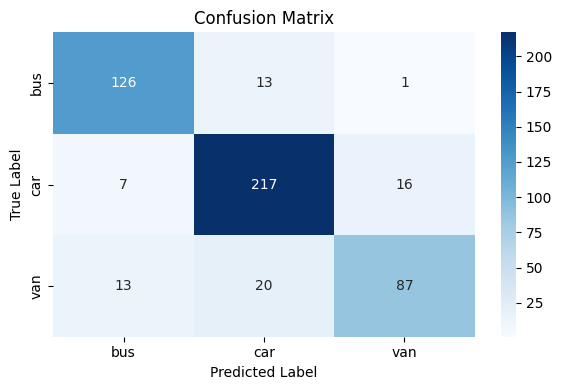

In [202]:
# Klassenlabels aus dem LabelEncoder holen, falls noch nicht vorhanden
class_names = le.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Model Random Forest Classifier 

In [203]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [204]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
clf = classification_report(y_test, y_pred)

print(f"The accuracy_score is: {acc * 100:.2f} %")
print(clf)

The accuracy_score is: 95.00 %
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       140
           1       0.95      0.97      0.96       240
           2       0.94      0.88      0.91       120

    accuracy                           0.95       500
   macro avg       0.95      0.94      0.95       500
weighted avg       0.95      0.95      0.95       500



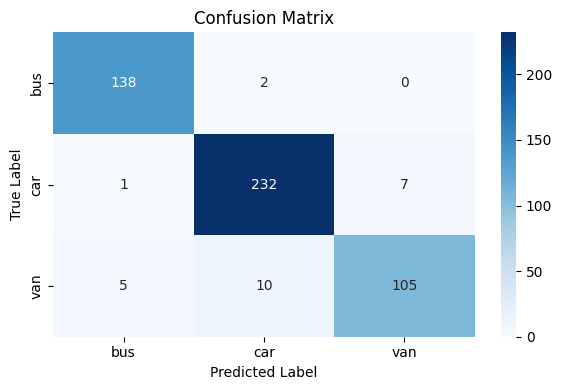

In [205]:
# Klassenlabels aus dem LabelEncoder holen, falls noch nicht vorhanden
class_names = le.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Model SVM

In [206]:
from sklearn.svm import SVC


model = SVC(kernel="rbf", class_weight="balanced", random_state=42)

model.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=42)

In [207]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
clf = classification_report(y_test, y_pred)

print(f"The accuracy_score is: {acc * 100:.2f} %")
print(clf)

The accuracy_score is: 62.80 %
              precision    recall  f1-score   support

           0       0.50      0.73      0.60       140
           1       0.82      0.56      0.67       240
           2       0.58      0.64      0.61       120

    accuracy                           0.63       500
   macro avg       0.63      0.64      0.62       500
weighted avg       0.67      0.63      0.63       500



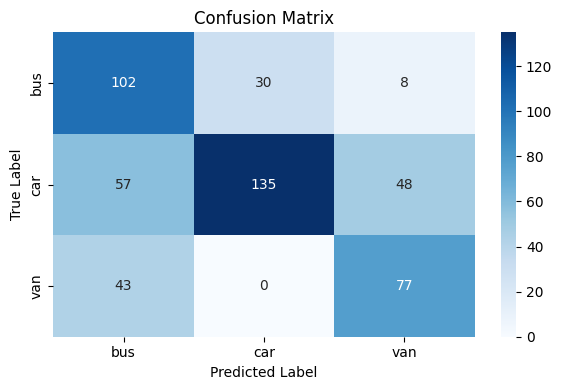

In [208]:
# Klassenlabels aus dem LabelEncoder holen, falls noch nicht vorhanden
class_names = le.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [209]:
print(X_train.isna().sum().sum())  # Anzahl fehlender Werte im Training
print(X_test.isna().sum().sum())   # im Testset


0
0


In [210]:
from sklearn.svm import SVC


model = SVC(kernel="rbf", class_weight="balanced", random_state=42)

model.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=42)

In [211]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
clf = classification_report(y_test, y_pred)

print(f"The accuracy_score is: {acc * 100:.2f} %")
print(clf)

The accuracy_score is: 62.80 %
              precision    recall  f1-score   support

           0       0.50      0.73      0.60       140
           1       0.82      0.56      0.67       240
           2       0.58      0.64      0.61       120

    accuracy                           0.63       500
   macro avg       0.63      0.64      0.62       500
weighted avg       0.67      0.63      0.63       500



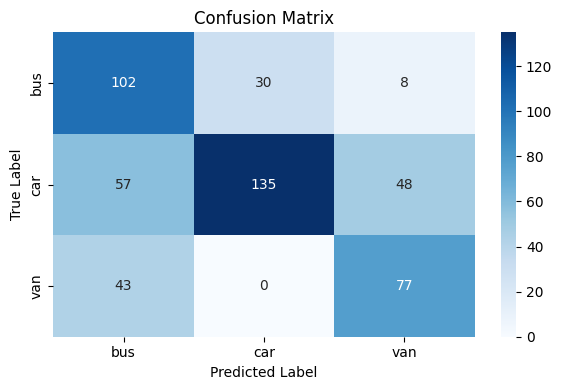

In [212]:
# Klassenlabels aus dem LabelEncoder holen, falls noch nicht vorhanden
class_names = le.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Model Logistic Regression (Bestes Ergebnis)

In [213]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=2000, class_weight="balanced", random_state=42)
model.fit(X_train, y_train)


d:\Git-GitHub\Repositories\data-science-track\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

In [214]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
clf = classification_report(y_test, y_pred)

print(f"The accuracy_score is: {acc * 100:.2f} %")
print(clf)

The accuracy_score is: 95.60 %
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       140
           1       0.99      0.93      0.96       240
           2       0.94      0.97      0.96       120

    accuracy                           0.96       500
   macro avg       0.95      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



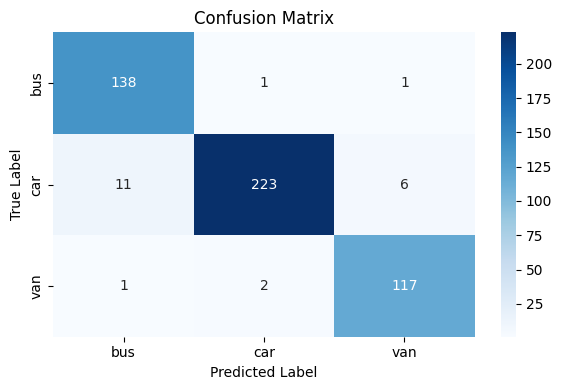

In [215]:
# Klassenlabels aus dem LabelEncoder holen, falls noch nicht vorhanden
class_names = le.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Multimodel - Autoselect mit vorhergehender Anpassung

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import time
import pandas as pd

# 🧹 Features, die wir als redundant identifiziert haben
drop_features = [
    "scaled_variance.1",
    "max.length_rectangularity",
    "distance_circularity"
]

# 🔄 X und y neu definieren auf Basis des reduzierten Sets
X_reduced = df_imputed.drop(columns=drop_features + ["label"])
y_reduced = df_imputed["label"]

# 📤 Train/Test-Split auf reduzierten Daten
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=500, random_state=42)

# 📦 Modelle, die getestet werden sollen
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "SVC": SVC(kernel="rbf", class_weight="balanced", random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)
}

# 📊 Ergebnisse sammeln
results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    duration = end - start

    results.append({
        "Model": name,
        "Accuracy": round(acc * 100, 2),
        "F1 (macro)": round(f1, 4),
        "Train Time (s)": round(duration, 3)
    })

# 📈 Ergebnis-DataFrame anzeigen
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="F1 (macro)", ascending=False))


                 Model  Accuracy  F1 (macro)  Train Time (s)
2  Logistic Regression      93.4      0.9327           0.331
0        Random Forest      92.4      0.9178           0.070
1                  SVC      62.2      0.6080           0.000


d:\Git-GitHub\Repositories\data-science-track\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


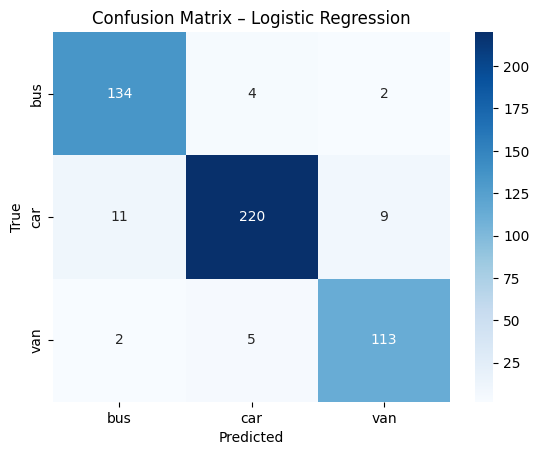

              precision    recall  f1-score   support

         bus       0.91      0.96      0.93       140
         car       0.96      0.92      0.94       240
         van       0.91      0.94      0.93       120

    accuracy                           0.93       500
   macro avg       0.93      0.94      0.93       500
weighted avg       0.94      0.93      0.93       500



In [221]:
# Bestes Modell nach F1 bestimmen
best_model_name = results_df.sort_values(by="F1 (macro)", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

# Vorhersagen und Confusion Matrix anzeigen
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – {best_model_name}")
plt.show()

# Optional:
print(classification_report(y_test, y_pred, target_names=le.classes_))


**Erkenntnisse:**<br>

Nach dem Entfernen stark korrelierter Merkmale konnte bei der Logistic Regression kein Leistungsgewinn erzielt werden – im Gegenteil: Die Accuracy sank leicht auf 93,4 %. Das zeigt, dass eine Reduktion redundanter Merkmale nicht automatisch zu besseren Ergebnissen führt. Manche dieser Merkmale enthalten möglicherweise dennoch ergänzende Trenninformation, die für lineare Modelle wie die Logistic Regression relevant ist.


# Conclusuins